<a href="https://colab.research.google.com/github/roshjaison03/A-Simple-ERP-for-Sales-and-Employee-Management-System/blob/master/Transformer_using_SWIglu_%26_RoPe_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Took reference from** https://github.com/FareedKhan-dev/create-million-parameter-llm-from-scratch.git

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import urllib.request

# **We will be adding hyperparameters inside MASTER_CONGIG after each important architectural blocks**

In [4]:
MASTER_CONGIG = {}

# **Dataset is a mix of Mark Twain books**

In [5]:
lines = open('Test_dataset.txt','r').read()
sorted_lines = sorted(list(set(lines)))
print('Printing the first 10 characters of the vocab list:', sorted_lines[:10])

print('Total number of characters in our dataset (Vocabulary Size):', len(sorted_lines))

Printing the first 10 characters of the vocab list: ['\n', ' ', '!', '"', '$', '%', '&', "'", '(', ')']
Total number of characters in our dataset (Vocabulary Size): 92


In [6]:
stoi = {character : index for index,character in enumerate(sorted_lines)}

itos = {index:character for index,character in enumerate(sorted_lines)}

In [ ]:
list(stoi.keys())[:10]
list(stoi.items())[:10]

[('\n', 0),
 (' ', 1),
 ('!', 2),
 ('"', 3),
 ('$', 4),
 ('%', 5),
 ('&', 6),
 ("'", 7),
 ('(', 8),
 (')', 9)]

In [ ]:
list(itos.keys())[:10]
list(itos.items())[:10]

[(0, '\n'),
 (1, ' '),
 (2, '!'),
 (3, '"'),
 (4, '$'),
 (5, '%'),
 (6, '&'),
 (7, "'"),
 (8, '('),
 (9, ')')]

In [7]:
def encode(x):
  return [stoi[ch] for ch in x]

encode('morning')

output: [69, 71, 74, 70, 65, 70, 63] **bold text**

In [8]:
def decode(l):
    return ''.join([itos[i] for i in l])

decode([69, 71, 74, 70, 65, 70, 63])

output = ['m', 'o', 'r', 'n', 'i', 'n', 'g']

In [9]:
dataset = torch.tensor(encode(lines),dtype=torch.int8)
dataset.shape

torch.Size([1104041])

# **For Test purposes we are taking 1 Million charater dataset**

## torch.Size([1104041])

In [10]:
MASTER_CONGIG = {
    "vocab_size":len(sorted_lines)
}

In [11]:
def get_batches(data,split,batch_size,context_window,config=MASTER_CONGIG):
  train = data[:int(.8*len(data))]
  val = data[int(.8*len(data)):int(.9*len(data))]
  test = data[int(.9*len(data)):]

  batch_data = train
  if split == 'val':
    batch_data = val
  if split == 'test':
    batch_data = test

  ix = torch.randint(0,batch_data.size(0) - context_window -1,(batch_size,))

  x = torch.stack([batch_data[i:i+context_window]for i in ix]).long()
  y = torch.stack([batch_data[i+1:i+context_window+1]for i in ix]).long()

  return x,y

In [42]:
MASTER_CONGIG.update({
    'batch_size': 16,
    'context_window': 16
})

In [43]:
xs,ys = get_batches(dataset,'train',MASTER_CONGIG['batch_size'],MASTER_CONGIG['context_window'])
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]
decoded_samples[:10]

[('the\ntime--a conf', 'he\ntime--a confe'),
 ('e, but the news ', ', but the news h'),
 ('but two instance', 'ut two instances'),
 (' of a tree till ', 'of a tree till h'),
 ('n-factories\nand ', '-factories\nand l'),
 ("A's ground. A sa", "'s ground. A sai"),
 ('28, twenty-one s', '8, twenty-one st'),
 ("'those Lake Prov", 'those Lake Provi'),
 (' off this time,\n', 'off this time,\nw'),
 (' had no luck. I ', 'had no luck. I e')]

In [44]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

In [45]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [46]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

In [47]:
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):

        b, m, d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

In [48]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(.1)

    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [60]:
class simple_test_model(nn.Module):
  def __init__(self,config = MASTER_CONGIG):
    super().__init__()
    self.config = config
    self.Embedding = nn.Embedding(config['vocab_size'],config['d_model'])
    self.rms = RMSNorm((config['context_window'], config['d_model']))
    self.rope_attention = RoPEMaskedMultiheadAttention(config)
    self.linear = nn.Sequential(
        nn.Linear(config['d_model'],config['d_model']),
        SwiGLU(config['d_model']),
    )
    self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
    print("Model parameters:",sum([m.numel() for m in self.parameters()]))

  def forward(self,idx,targets=None):
    x = self.Embedding(idx)
    x = self.rms(x)
    x = x + self.rope_attention(x)
    x = self.rms(x)
    x = x + self.linear(x)
    logits = self.last_linear(x)
    if targets is not None:
      loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
      return logits, loss
    else:
        return logits

In [61]:
MASTER_CONGIG.update({
    'd_model': 128,
    'n_heads': 8,
})

model = simple_test_model(MASTER_CONGIG)

print("Total number of parameters in the Simple Neural Network Model:", sum([m.numel() for m in model.parameters()]))

Model parameters: 599645
Total number of parameters in the Simple Neural Network Model: 599645


In [62]:
MASTER_CONGIG.update({
    'epochs': 10000,
    'log_interval': 1000,
    'batch_size': 64,
})

In [63]:
xs, ys = get_batches(dataset, 'train', MASTER_CONGIG['batch_size'], MASTER_CONGIG['context_window'])
logits, loss = model(xs, ys)

In [64]:
model = simple_test_model(MASTER_CONGIG)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.01
)

Model parameters: 599645


In [65]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10_000
)


In [66]:
@torch.no_grad()
def evaluate_loss(model,config=MASTER_CONGIG):
  out = {}
  model.eval()
  for split in ["train","val"]:
    losses = []
    for _ in range(10):
      xy,yb = get_batches(dataset, split, MASTER_CONGIG['batch_size'], MASTER_CONGIG['context_window'])
      _,loss = model(xy,yb)
      losses.append(loss.item())
    out[split] = np.mean(losses)
  model.train()
  return out

Epoch 0 | val loss 4.643 | Time 0.220 | ETA in seconds 2.201
lr:  [0.00029999998519559363]
Epoch 1000 | val loss 2.144 | Time 144.283 | ETA in seconds 1298.549
lr:  [0.0002926293399246247]
Epoch 2000 | val loss 2.020 | Time 142.442 | ETA in seconds 1139.533
lr:  [0.00027129714255383494]
Epoch 3000 | val loss 2.008 | Time 141.954 | ETA in seconds 993.680
lr:  [0.0002380915371919154]
Epoch 4000 | val loss 1.949 | Time 138.535 | ETA in seconds 831.209
lr:  [0.00019626291984859811]
Epoch 5000 | val loss 1.920 | Time 138.924 | ETA in seconds 694.622
lr:  [0.00014990576702634875]
Epoch 6000 | val loss 1.975 | Time 139.198 | ETA in seconds 556.793
lr:  [0.00010355783983234435]
Epoch 7000 | val loss 1.920 | Time 142.978 | ETA in seconds 428.935
lr:  [6.175599630466276e-05]
Epoch 8000 | val loss 1.903 | Time 141.070 | ETA in seconds 282.139
lr:  [2.859209213661384e-05]
Epoch 9000 | val loss 1.887 | Time 141.747 | ETA in seconds 141.747
lr:  [7.312441326764493e-06]
Validation loss:  1.8865782380

<Axes: >

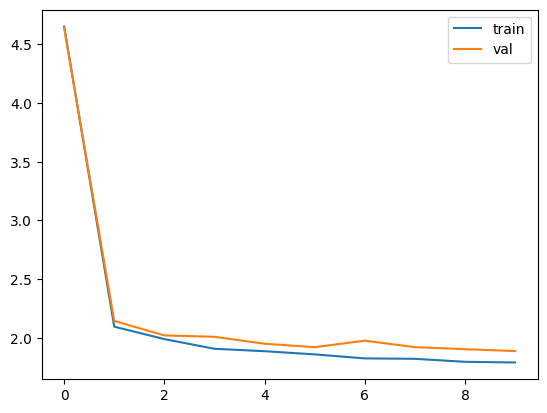

In [67]:
def train(model, optimizer, scheduler, config=MASTER_CONGIG, print_logs=True):
    losses = []

    start_time = time.time()

    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]

            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")

            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("Validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer,scheduler)

In [59]:
#del model

In [68]:
def generate(model, config=MASTER_CONGIG, max_new_tokens=200):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]
        p = F.softmax(last_time_step_logits, dim=-1)
        idx_next = torch.multinomial(
            p, num_samples=1
        )
        idx = torch.cat([idx, idx_next], dim=-1)
    return [decode(x) for x in idx.tolist()]

generate(model)

["\nThe walk _with refour my has bodo.\nOne and en young may do the to ge\nbad the bratches day siguaphaloting you of pathe y packs a whose, and at upEvorys. PLoI coveryges.'\n'For\nwhich tention, frest be; n",
 "\not tathe same a river and lowelvosing, and going to do, in aboun to 'Vid watch he! Whis I diself shaow Bnich andeled\nin the sort of\nspemed ther was cleep to that teat the the stile there the Massno Re",
 "\nunderces to we\nron you chountry wish this and a nufectewed theman, than\nis the befet, it advering out undid the\nstableguing in thing deeps iny is baboy-s' witanis not vent parteamed derges thing onsti",
 '\nwhat be an my the\nwas us\nheambotion of Scuctoured use sccond\nof the chese ask; it what tossapples aid in the him the treat the with the Stated barted Yakesen mase simble, I that, and rugly SMated st\ns',
 '\nTOh whome in two the then to enere were in\nthis and\ngo ruderick--anotten, fulubg, Vlobliation the borth lit, waited expected you broff thisting the pure 